# Image classification with Perceptrons

## Handwritten Digit Classification

- We are going to use **perceptron classifier** to classify (recognize) given digit images. Since, a single perceptron could only be used for binary classification, we initially consider only two classes. Later, we extend it to the multi-class setting.
- Suppose we want to recognize whether the given image is of digit zero or not (digit other than zero). Then the problem could be cast as a binary classification problem.

## Introduction

In supervised learning paradigm, we have two major types of learning-
1. Regression
2. Classification

In this notebook, we tackle classification problem by considering the image classification as a running example and solving it using the **Perceptron** model.

## Imports

- For classification problems, we need to import classes and utilities from `sklearn.linear_model`.
    - This module has implementations for different classification models like `Perceptron`, `Logistic Regression`, `svm` and `knn`.
- We also need to import a bunch of model selection utilities from `sklearn.model_selection` module and metrics from `sklearn.metrics` module.
- The data processing utilities are imported from `sklearn.preprocessing` modules.


In [2]:
# Common imports
import numpy as np
import pandas as pd
import os
import io
import warnings

# sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, precision_score, recall_score, classification_report, make_scorer
from sklearn.model_selection import train_test_split ,cross_validate, cross_val_score, GridSearchCV
from pprint import pprint

# To plot pretty plots
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

Setting random seed, to reproduce random data:

In [3]:
np.random.seed(42)

## Data

- As our first step, we create a dataset, that contains a collection of digit images written by humans. Then each image should be labelled properly.
- Fortunately, we have a standard benchmark called **MNIST**, which is what we will be using in this notebook.

### Loading

In [4]:
X,y = fetch_openml('mnist_784', version=1, return_X_y=True)

Note: The data is downloaded to your `HOME` (`~\`) directory, inside the `scikit_learn_data` folder.

In [5]:
print(type(X), type(y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


This already returns Data and label as pandas dataframe and series.

The data matrix $X$ and respectively the label vector $y$ need to be converted to the numpy array by calling the `to_numpy` method.

In [6]:
X = X.to_numpy()
y = y.to_numpy()

print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


- Let's get some information like number of features, number of classes about the dataset.
- Observe that the labels are of string data type but not integers.

In [7]:
target_names = np.unique(y)

print('Number of samples: {0}, type: {1}'.format(X.shape[0], X.dtype))
print('Number of features: ', X.shape[1])
print('Minimum: {0}, Maximum: {1}'.format(np.min(X), np.max(X))) # Prints the maximum and minimum entry in each entry
print('Number of classes: {0}, type: {1}'.format(len(target_names),y.dtype))
print('Labels: ', target_names)

Number of samples: 70000, type: float64
Number of features:  784
Minimum: 0.0, Maximum: 255.0
Number of classes: 10, type: object
Labels:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


- The MNIST dataset is clean and the range of values that each feature can take is also known. Therefore, the samples in the dataset may not require many data preprocessing techniques.
- However, we will scale the range of features between $0$ and $1$.
- So, we can either use `MinMaxScaler` or `MaxAbsScaler`. They don't make any difference as the image pixels can take on positive values from $0$ to $255$.

### Visualization

Let's pick a few images (images are already shuffled in the dataset) and display them with their respective labels.

The images are stacked as row vector of $1 \times 784$ and therefore must be reshaped to the matrix of size $28 \times 28$ to display them properly.

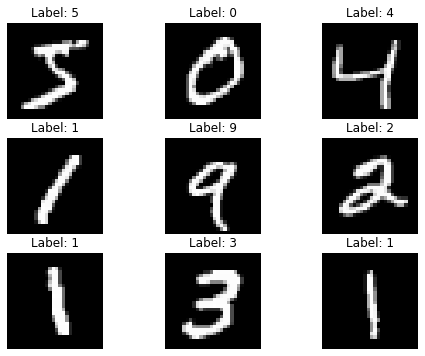

In [8]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('Label: ' + str(y[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

If we closely observe, we can see that there are moderate variations in the appearance of the digits (say, digit $1$). These matrices are also close to sparse (that is, ther are lots of zeros (black pixels) in the matrix than non-zero pixels).

We can inspect the image pixel value and ask some interesting questions such as:
1. What is the range of pixel values?
2. Are the pixel values highly correlated?
3. Is the data sparsed?
4. What is the range of values that a single pixel(element) can take?
5. Do we need to apply any pre-processing methods?

We look at a single example first.

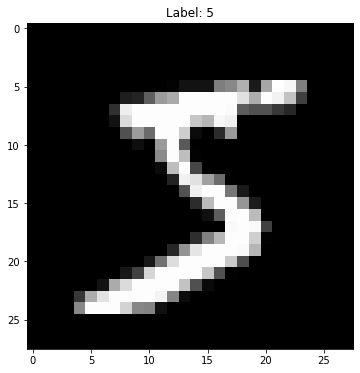

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.title('Label: ' + str(y[0]))
plt.show()

### Data Splitting

- Now, that we know the deatils such as number of samples, size of each sample, number of features (784), number of classes (targets) about the dataset, we can move on to the splitting and pre processing steps.
- We split the total no. of samples into train and test sets. Out of the total examples of $70000$, we keep $10000$ for testing and the remaining for training.
- Since, the samples in the dataset are already randomly shuffles, we need not shuffle it again. Therefor, I am not using `train_test_split` here.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeding further, we need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of samples in each classes.

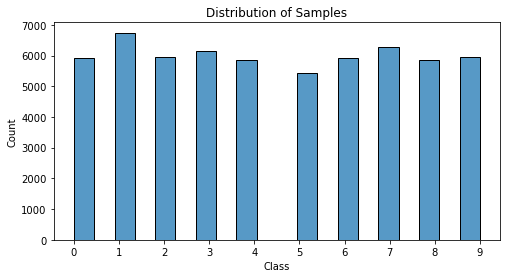

In [11]:
plt.figure(figsize=(8,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

The data seems pretty balanced, as each label is almost equally represented.

# Binary Classification: 0 detector

## Modifying Labels

- We start with a simple classification problem, that is binary classification.
- Since the original label vector contains $10$ classes, we need to modify the no. of classes to just $2$.
- Therefore, the label $0$ will be changed to $+1$ and all other labels ($1-9$) will be changed to $-1$.
- We name the label vectors as `y_train_0` and `y_test_0`.

Inorder to accomplish this, we define a helper function.

In [16]:
def bin_label_converter(y, class_name):
    '''Converts given multiclass label vector to one vs all binary form.
        Labels with labels `class_name` are assigned +1, and everything else is assigned -1.
    '''
    return np.where(y == class_name, 1, -1)

In [17]:
y_train_0, y_test_0 = bin_label_converter(y_train, '0'), bin_label_converter(y_test, '0')

Now, we conduct a sanity check. Let's display the elements of `y_train` and `y_train_0` to verify whether all the labels are properly modified or not.

We will conduct the check on a few examples.

In [18]:
print(y_train) # Original labels
print(y_train_0) # Modified labels

['5' '0' '4' ... '5' '6' '8']
[-1  1 -1 ... -1 -1 -1]


In [19]:
print(np.where(y_train == '0')) # index of labels with '0' in the original label vector
print(np.where(y_train_0 == 1)) # index of labels with '+1' in the modified label vector

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


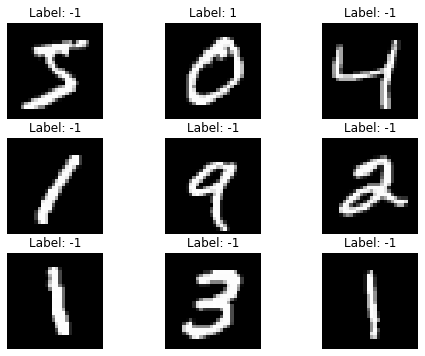

In [20]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_train[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('Label: ' + str(y_train_0[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

## Baseline Model

Let's construct a baseline model with the following rules:
1. Count the no. of samples per class.
2. The model always outputs the class with highest no. of samples.
3. Then we check the accuracy of the baseline model.

In [28]:
unique, counts = np.unique(y_train_0, return_counts=True)
print(unique, counts)

[-1  1] [54077  5923]


As we can see, we have $54077$ occurences of $-1$ and only $5923$ occurences of $+1$, which means just returning $-1$ should be a pretty decent baseline model.

In [29]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train_0)

DummyClassifier(strategy='most_frequent')

Now, we check the accuracy of this baseline model.

In [30]:
print("Score on Training Set: ", dummy_clf.score(X_train, y_train_0))
print("Score on Test Set: ", dummy_clf.score(X_test, y_test_0))

Score on Training Set:  0.9012833333333333
Score on Test Set:  0.902


The reason to this is obvious. The model would have predicted $54077$ samples correctly out of the $60000$ by just giving an output of $-1$, irrespective of the input sample.

Therefore the accuracy will be $\frac{54077}{60000}$, which is around $90.12 \%$.

> This is the reason why **accuracy** alone is not always a good measure, as it can be hoodwinked fairely easily.

## Perceptron Model

Let's look at the  `Perceptron` class from `sklearn.linear_model`.

`(class) Perceptron(*, penalty=None, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, eta0=1, n_jobs=None, random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False)`

- Internally this is just the `SGDClassifier` API that uses the perceptron loss (i.e. it calls `Hinge(0.0)`, where `0.0` is the threshold) and uses SGD to update weight.
- So, another way of deploying Perceptron is to use general `sklearn.linear_model.SGDClassifer` with the parameter `loss = 'perceptron'`.

In [81]:
from sklearn.linear_model import Perceptron

prcp_clf_0 = Perceptron(max_iter=100, random_state=69)

### Training and Prediction (without Validation)

Initially we do the training without any validation.

- Call the `fit` method to train the model.
- Later, I will use the `partial_fit` method to visualize the *Learning Curve* for this Perceptron.

In [82]:
prcp_clf_0.fit(X_train, y_train_0)

Perceptron(max_iter=100, random_state=69)

In [83]:
pred_weights = prcp_clf_0.coef_
print("Shape of weight vector: ", pred_weights.shape)
print("Bias", prcp_clf_0.intercept_)
print("The loss function: ", prcp_clf_0.loss_function_)

Shape of weight vector:  (1, 784)
Bias [-1278.]
The loss function:  <sklearn.linear_model._sgd_fast.Hinge object at 0x1503e7af0>


Let's make prediction on Training and Test set and check their accuracy.

In [84]:
print("Training Accuracy: ", prcp_clf_0.score(X_train, y_train_0))
print("Test Accuracy: ", prcp_clf_0.score(X_test, y_test_0))

Training Accuracy:  0.9901333333333333
Test Accuracy:  0.9917


### Visualizing Predictions

We visualize the true labels and prediction on a few examples in the test set.

In [85]:
# Predicted labels for the test set.
y_test_hat = prcp_clf_0.predict(X_test)

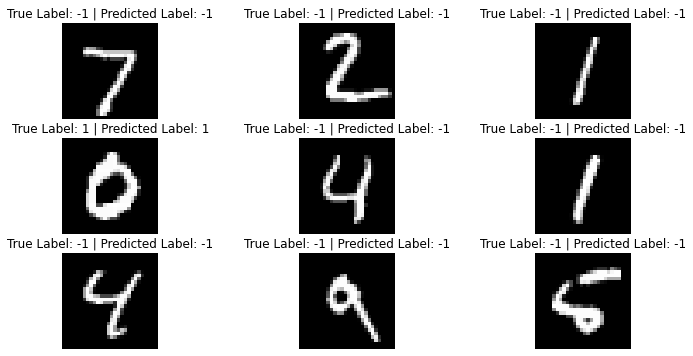

In [86]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test_0[index]) + ' | Predicted Label: ' + str(y_test_hat[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

Now, we display a couple of images from the positive test class, along with their predictions.

In [87]:
index_pos = np.array(np.where(y_test_0 == 1)).reshape(-1,) # It lists out an array with indexes with have been labelled +1 in the test label set.
index_pos.shape

(980,)

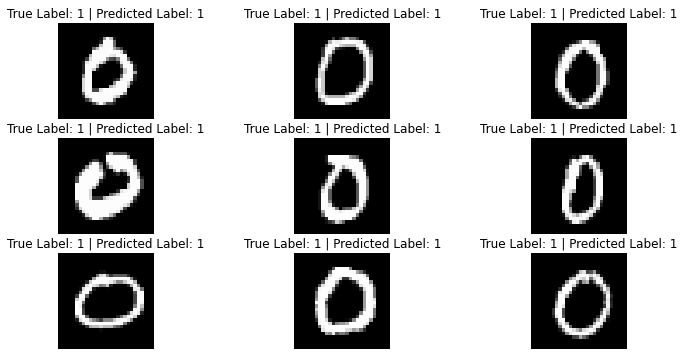

In [88]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images following the index from the array of indices index_pos
i = 0
for row in range(factor):
    for col in range(factor):
        index = index_pos[i]
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test_0[index]) + ' | Predicted Label: ' + str(y_test_hat[index]))
        ax[row,col].set_axis_off()
        i += 1

plt.show()

It seems as if our model is performing decently. Let's analyze the performance using some other evaluation metrics.

In [89]:
index_misclassified = np.array(np.where(y_test_hat != y_test_0)).reshape(-1,)
num_missclassified = len(index_misclassified)
accuracy = 1 - (num_missclassified/len(y_test_0))
print(accuracy)
# This is exactly same as the score obtained above using - `prcp_clf_0.score(X_test, y_test_0)`

0.9917


Let's try the above binary classification exercise by attaching $+1$ to labels with $5$ and $-1$ to others.

In [76]:
y_train_5, y_test_5 = bin_label_converter(y_train, '5'), bin_label_converter(y_test, '5')

Visualizing the data and modified labels.

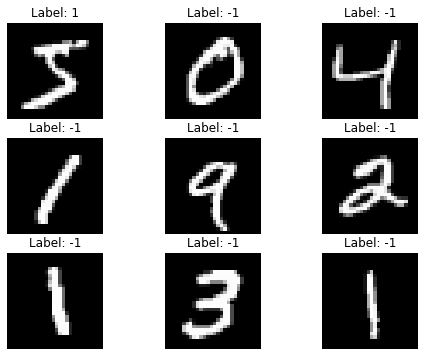

In [77]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_train[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('Label: ' + str(y_train_5[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

Training the model using the current training set.

In [90]:
from sklearn.linear_model import Perceptron

prcp_clf_5 = Perceptron(max_iter=100, random_state=69)

In [91]:
prcp_clf_5.fit(X_train, y_train_5)

Perceptron(max_iter=100, random_state=69)

Let's check the accuracy of training and test this time.

In [92]:
print("Training Accuracy: ", prcp_clf_5.score(X_train, y_train_5))
print("Test Accuracy: ", prcp_clf_5.score(X_test, y_test_5))

Training Accuracy:  0.9689833333333333
Test Accuracy:  0.9689


As we can see, this is actually a lot less than that with $0$, even though this is still a pretty decent accuracy.

Let's visualize the predictions on the test set.

In [93]:
# Predicted labels for the test set.
y_test_hat = prcp_clf_5.predict(X_test)

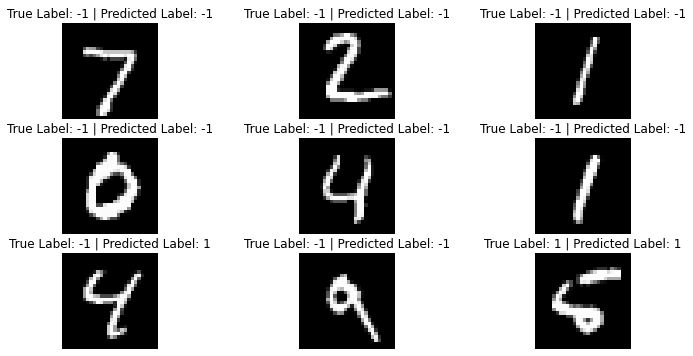

In [95]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test_5[index]) + ' | Predicted Label: ' + str(y_test_hat[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

In [96]:
index_pos = np.array(np.where(y_test_5 == 1)).reshape(-1,) # It lists out an array with indexes with have been labelled +1 in the test label set.
index_pos.shape

(892,)

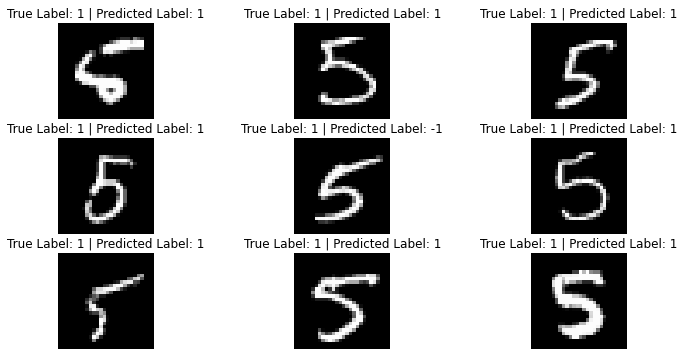

In [97]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images following the index from the array of indices index_pos
i = 0
for row in range(factor):
    for col in range(factor):
        index = index_pos[i]
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test_5[index]) + ' | Predicted Label: ' + str(y_test_hat[index]))
        ax[row,col].set_axis_off()
        i += 1

plt.show()

## Better Evaluation Metrics

We know that using 'accuracy' alone to measure performance of the model is not suitable (especially for imbalanced datasets).

So, we will take a look at some of the other evaluation metrics.

### Confusion Matrix

We plot the confusion matrix for the training set in the $0$ vs all classification.

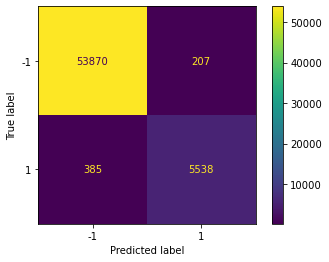

In [105]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_hat_0 = prcp_clf_0.predict(X_train)

cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_train_hat_0, values_format='.5g')
plt.show()

- We have $207$ FPs and $385$ FNs. Since, this is an unbalanced dataset, we would want our classifier to avoid FNs more.
- We can achieve this by computing other metrics that take FPs and FNs into account.

### Precision and Recall

- We can use the function `classification_report` to compute these parameters.
- We can also compute these manually from the confusion matrix as well.

In [107]:
cm = cm_display.confusion_matrix
print(cm)

[[53870   207]
 [  385  5538]]


In [108]:
tn = cm[0,0]
fn = cm[1,0]
fp = cm[0,1]
tp = cm[1,1]

precision = tp/(tp + fp)
recall = tp/(tp + fn)
accuracy = (tn + tp)/(tn + tp + fn + fp)

print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)

Precision:  0.9639686684073107
Recall:  0.9349991558331926
Accuracy:  0.9901333333333333


- This was all about the implementaion without cross validation.
- We can improve the model further using cross validation, and by tuning the hyperparameters further.

### Training and Prediction (with Cross Validation) - 1

- We use cross-validation folds and measure the same metrics across these folds for different values of hyperparameters.
- In this case of perceptrons, we will be focussing on learning rates. We initally set this to the default value.
- Later, we use `GridSearchCV` to find a better learning rate.

In [112]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_validate

prcp_clf_bin = Perceptron(max_iter=100, random_state=69)

scores = cross_validate(
    prcp_clf_bin,
    X_train,
    y_train_0,
    scoring=['precision', 'recall', 'f1'],
    cv = 5,
    return_estimator=True,
)

print(scores)

{'fit_time': array([1.39490294, 2.22016692, 1.28352785, 0.88187528, 1.77816296]), 'score_time': array([0.01978707, 0.01354909, 0.01266718, 0.01373291, 0.012918  ]), 'estimator': [Perceptron(max_iter=100, random_state=69), Perceptron(max_iter=100, random_state=69), Perceptron(max_iter=100, random_state=69), Perceptron(max_iter=100, random_state=69), Perceptron(max_iter=100, random_state=69)], 'test_precision': array([0.95971352, 0.92357724, 0.93946932, 0.92963576, 0.93057851]), 'test_recall': array([0.90540541, 0.95945946, 0.95611814, 0.94767932, 0.95021097]), 'test_f1': array([0.9317688 , 0.94117647, 0.94772062, 0.93857083, 0.94029228])}


**Note :**
- The perceptron estimator is passes as an argument to the function `cross_validate` and is internally cloned `num_fold` (`cv = 5`) times and fitted independently on each fold.
- We can measure the generalization capability by kooking at the average of errors across all folds.

In [113]:
print("Precision: ", scores['test_precision'].mean(), scores['test_precision'].std())
print("Recall: ", scores['test_recall'].mean(), scores['test_recall'].std())
print("F1: ", scores['test_f1'].mean(), scores['test_f1'].std())

Precision:  0.9365948696355044 0.012623936901038687
Recall:  0.9437746607366861 0.019632863858758245
F1:  0.9399057985835878 0.005115238700491762


- As we can see, most of them are close, with low variance, across the scoring metrics, which is a good sign.
- But amongnst these, the estimator in the 3rd fold, (the one with `f1_score = 0.9477`) seems to have performed the best. So, we will pick this model as our estimator and check that out in more details.

In [123]:
prcp_clf_0 = scores['estimator'][2] # We select the 3rd estimator

# Predicting on the test data.
y_test_hat_0 = prcp_clf_0.predict(X_test)

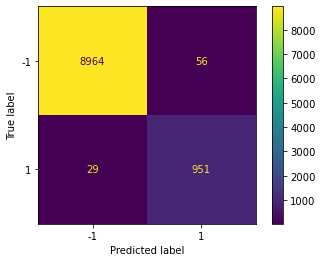

In [124]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_test_hat_0, values_format='.5g')

This seems decent enough.

### Training and Prediction (with Cross Validation) - 2

- We can follow another approach of getting predicted labels via cross-validation and using it to measure the generalization.
- In this case, each sample in the dataset will be part of only onne test set in the splitted folds. For this, we will be using `cross_val_predict` method.

In [132]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_predict

# We use the 'prcp_clf_0' from before
y_train_hat_0 = cross_val_predict(
    prcp_clf_0,
    X_train,
    y_train_0,
    cv = 5,    
)

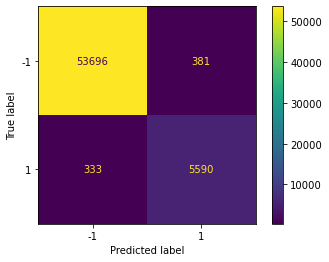

In [133]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_train_hat_0, values_format='.5g')
plt.show()

In [135]:
from sklearn.metrics import classification_report

print(classification_report(y_train_0, y_train_hat_0))

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99     54077
           1       0.94      0.94      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## Precision-Recall Tradeoff

- We often seem to notice an inverse relationship between 'Precision' and 'Recall'. Whenever precision increases/decreases, recall seems to decrease/increase and vice-versa.

- Precision: Accuracy of positive predictions.
$$\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}$$
- Recall: Also called sensitivity. It is the ratio of positive instances correctly detected.
$$\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$

- Now, decrease in Precision would imply a increase in FPs, which would naturally imply a decrease in FNs, as the model is biased towards giving more positive outputs.
- Similarly, a decrease in Recall would imply a increase in FNs, which would imply a decrease in FPs, as the model becomes more biased towards predicting negative outputs.

- Often, we need to decide which score to depend on. So, we need to make a trade off between precision and recall scores of a model.
- This depends on the problem at hand.

- It is important that we do not pass the **predicted labels** as input to the `precision_recall_curve` method. Instead we need to pass the probability scores or the output from the decision function. (For more info about ROC, PR Curves and AOC, follow this [article](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/))
- The `Perceptron` class contains a `decision_function` attribute, which we will make use of. Internally the decision scores are sorted and the TPs and FPs are computed by changing the threshold from `index[0]` to `index[1]`. (For more about perceptron decision function, follow this [article1](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron.decision_function) and [article2](https://www.geeksforgeeks.org/ml-decision-function/))
- Let's compare the scores from decision function from the previous example.

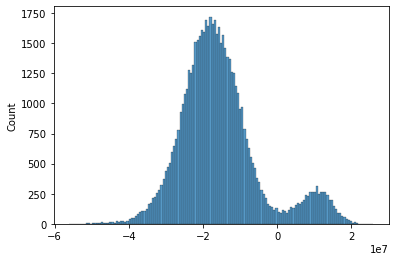

In [144]:
from sklearn.linear_model import Perceptron

prcp_clf_0 = Perceptron(random_state=69)
prcp_clf_0.fit(X_train, y_train_0)

y_scores = prcp_clf_0.decision_function(X_train)

plt.figure()
sns.histplot(y_scores)
plt.show()

As we can observe, there are many negative values instead of positives. This is because of class imbalance. Most of the points are accumulated on the negative side of the hyperplane (or decision boundary), which results in this graph (it basically considers $0$ to be the threshold value).

- Suppose threshold takes the value of $-3 \times 10^7$, then all the samples having a score greater than $-3 \times 10^7$ will be assigned the label $+1$ (Positive Label) and less than that will be set to $-1$ (Negative Label).
- Therefore, the no. of FPs will be high. This will tend to reduce the Precision Score.
- On the other hand, if we set the threshold to $2 \times 10^7$, then the no. of FNs will increase, which will result in reduction of Recall Score.
- We can visualize this via PR-curve (Precision-Recall Curve).


### Precision Recall Curve

In [147]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import precision_recall_curve

prcp_clf_0 = Perceptron(random_state=69)
prcp_clf_0.fit(X_train, y_train_0)

y_scores = prcp_clf_0.decision_function(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1) # pos_label denotes the label of positive class

In [149]:
print(precisions.shape, recalls.shape, thresholds.shape)
# While plotting we can leave out the last index to match the lengths of precisions, recalls and thresholds.

(55510,) (55510,) (55509,)


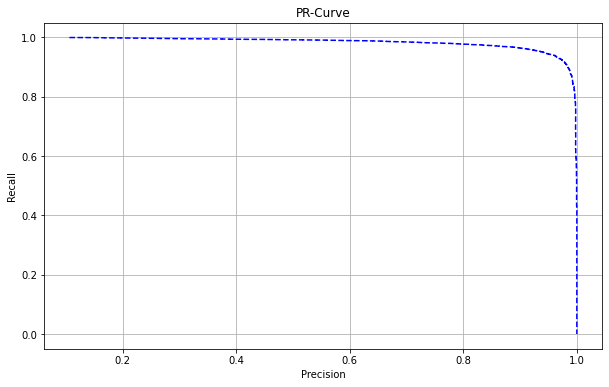

In [152]:
plt.figure(figsize=(10,6))
plt.plot(precisions[:-1], recalls[:-1], 'b--')
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR-Curve")
plt.grid(True)
plt.show()

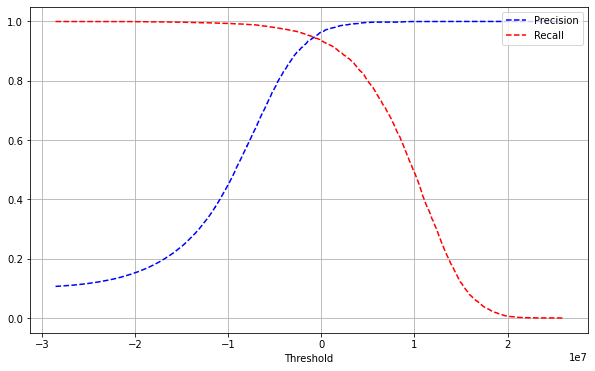

In [158]:
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
plt.plot(thresholds, recalls[:-1], 'r--', label="Recall")
plt.xlabel("Threshold")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

- We can clearly observe the inverse relationship between Precision and Recall.
- Now, we should be thinking about how to increase the precision of the classifier by compromising the recall. We basically make use of the above plot.
- Using the predicted output and score, we shift the sigmoid/activation threshold to our liking and tweak the output accordingly.

- Now, how do we grab a good threshold?
    - First we obtain a rough range of thresholds based on the PR-Threshold graph.
    - We can notice that a threshold close to $0$ should do a decent job.
    - Let's zoom in a bit, to the thresholds between $0$ and $0.25 * 10^7$.

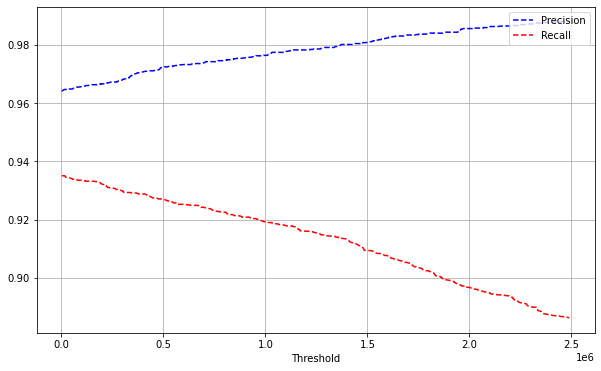

In [160]:
# We narrow down to our indices holding the required threshold range.
threshold_index = np.where(np.logical_and(thresholds>0 * 1e7, thresholds<0.25 * 1e7))

plt.figure(figsize=(10,6))
plt.plot(thresholds[threshold_index], precisions[threshold_index], 'b--', label="Precision")
plt.plot(thresholds[threshold_index], recalls[threshold_index], 'r--', label="Recall")
plt.xlabel("Threshold")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

So, the threshold close to $1.0 * 10^6$ seems decent. So lets choose that.

In [173]:
# We narrow down to our indices holding the required threshold range.
threshold_index = np.array(np.where(np.logical_and(thresholds>=1.0 * 1e6, thresholds<1.5 * 1e6)))

final_th_index = threshold_index[0,0]
final_th = thresholds[final_th_index]
final_th

1005751.0

- Now, that we have decided on the threshold, we need to shift our outputs accordingly.
- We implement a helper function to help us do the same.

In [166]:
def predict_new(y_scores, threshold=0):
    '''This takes in the scores obtained by the each sample as input and classifies them to +1 or -1 based on whether the corresponding score is >= threshold or < threshold.
        
        Note: The y_scores is obtained by using the `decision_function` on the `Perceptron` object after fitting it with the training data and labels.
    '''
    # Shifted prediction
    y_pred_shifted = np.where(y_scores>= threshold, 1, -1)
    return y_pred_shifted

Now, lets evaluate our new shifted outputs.

In [174]:
from sklearn.metrics import classification_report

y_train_hat_0_th = predict_new(y_scores, threshold=final_th)
print(classification_report(y_train_0, y_train_hat_0_th))

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99     54077
           1       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



- We have managed to improve precision (of `1`) from `0.94` previously to `0.98`!

### The ROC Curve

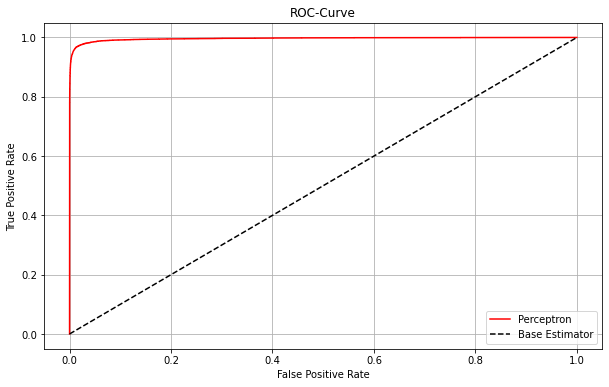

In [176]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, 'r-', label="Perceptron")
plt.plot([0,1], [0,1], 'k--', label="Base Estimator")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.title("ROC-Curve")
plt.show()

## Warm Start vs Cold Start

### Cold Start

- If we execute the `fit` method of `prcp_clf_0` repeatedly, we get the same score for both training and testing accuracy.
- This is because everytime the `fit` method is called, the model weights are initialized to the same values. Therefore, we always obtain the same score.
- This is termed as **cold start**.

In [183]:
score_list = []

Let's execute the following cell 3 times and append the score into the score list and check the score.

In [186]:
from sklearn.linear_model import Perceptron

prcp_clf_0 = Perceptron(random_state=69) # Warm start is off by default

for _ in range(3):
    prcp_clf_0.fit(X_train, y_train_0)
    score_list.append(prcp_clf_0.score(X_train, y_train_0))

print(score_list)

[0.9901333333333333, 0.9901333333333333, 0.9901333333333333]


### Warm Start

- Setting the attribute `warm_start=True` while instantiating the Perceptron object, enables the perceptron to remember the weights obtained in the previous execution.
- This is helpful in many ways. When there is lack of resources, it can help us pause the training and resume it whenever there is sufficient resource available for training again.
- This is really not necessary for this example, because it is small.
- But, we can use this to plot the learning curve for Perceptron. We can pause and record the loss after every iteration and continue where we left off using this feature.

In [187]:
score_list = []

Let's execute the following cell 3 times and append the score into the score list and check the score.

In [188]:
from sklearn.linear_model import Perceptron

prcp_clf_0 = Perceptron(warm_start=True, random_state=69)

for _ in range(3):
    prcp_clf_0.fit(X_train, y_train_0)
    score_list.append(prcp_clf_0.score(X_train, y_train_0))

print(score_list)

[0.9901333333333333, 0.9883, 0.9860666666666666]


As we can see, the training accuracy changes after each iteration.

## Learning Curves

We finally take a look at the iteration vs loss curves. We do this via `partial_fit` method in the Perceptron class. This can also be done by setting `warm_start=True`.

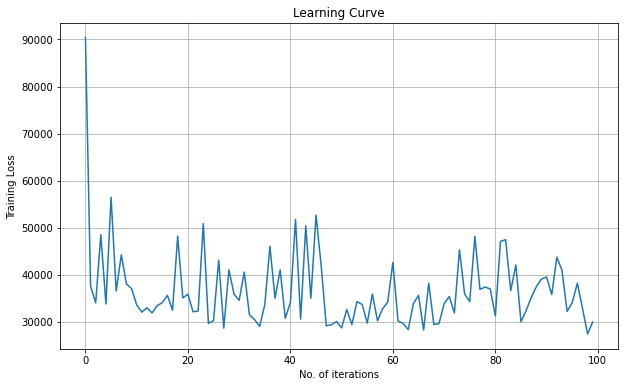

In [227]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss

iterations= 100

prcp_0_lc = Perceptron(max_iter=1000, random_state=69)
loss_0_lc = []

# Storing the loss per iteration
for _ in range(iterations):
    prcp_0_lc.partial_fit(X_train, y_train_0, classes=np.array([1, -1]))
    y_0_scores = prcp_0_lc.decision_function(X_train)
    loss_0_lc.append(hinge_loss(y_train_0, y_0_scores))

# Plotting the loss vs iteration curve
plt.figure(figsize=(10,6))
plt.plot(np.arange(iterations), loss_0_lc)
plt.xlabel("No. of iterations")
plt.ylabel("Training Loss")
plt.title("Learning Curve")
plt.grid(True)
plt.show()

## `GridSearchCV`

- So far we didn't do any hyperparameter tuning. We accepted the default values of learning rate of the Perceptron class.
- Now, we will search for a better learning rate using `GridSearchCV`
- No matter what the learning rate is, the loss will never converge to zero as the classes are not linearly separable.

In [222]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer # Could also have used 'sklearn.model_selection.ShuffleSplit' as scorer
from sklearn.linear_model import Perceptron

lr_list = [1/2**n for n in range(1,6)]

hinge_scorer = make_scorer(hinge_loss, greater_is_better=False)
param_grid = {
    'eta0' : lr_list,
}

bin_clf_gscv = GridSearchCV(
    Perceptron(random_state=69),
    param_grid=param_grid,
    scoring=hinge_scorer,
    cv = 5,
)

bin_clf_gscv.fit(X_train, y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(random_state=69),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [224]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.56626644, 1.50511818, 1.54342313, 1.57829704, 1.660179  ]),
 'mean_score_time': array([0.00816741, 0.00651278, 0.00814457, 0.00687375, 0.00635743]),
 'mean_test_score': array([-0.0238, -0.0238, -0.0238, -0.0238, -0.0238]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([1, 1, 1, 1, 1], dtype=int32),
 'split0_test_score': array([-0.02616667, -0.02616667, -0.02616667, -0.02616667, -0.02616667]),
 'split1_test_score': array([-0.02366667, -0.02366667, -0.02366667, -0.02366667, -0.02366667]),
 'split2_test_score': array([-0.02083333, -0.02083333, -0.02083333, -0.02083333, -0.02083333]),
 'split3_test_score': array([-0.0245, -0.0245, -0.0245, -0.0245, -0.0245]),
 'split4

In [225]:
print(bin_clf_gscv.best_params_)

{'eta0': 0.5}


This gives the best learning rate of $0.5$. So, let's compare that with the previous model by plotting the learning curve.'

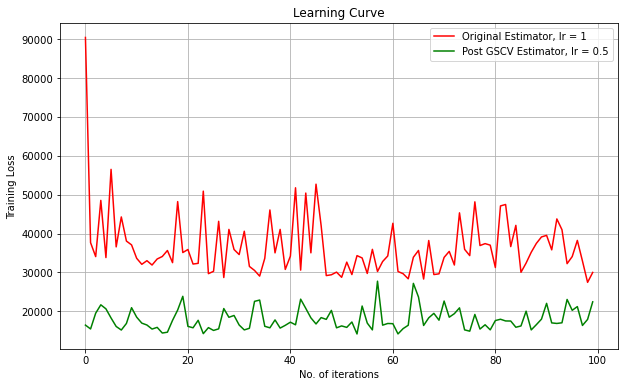

In [229]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss

iterations= 100

prcp_0_lc = Perceptron(max_iter=1000, random_state=69)
loss_0_lc = []

prcp_gscv_estimator = bin_clf_gscv.best_estimator_
loss_0_gscv = []

# Storing the loss per iteration
for _ in range(iterations):
    prcp_0_lc.partial_fit(X_train, y_train_0, classes=np.array([1, -1]))
    y_0_scores = prcp_0_lc.decision_function(X_train)
    loss_0_lc.append(hinge_loss(y_train_0, y_0_scores))

    prcp_gscv_estimator.partial_fit(X_train, y_train_0, classes=np.array([1, -1]))
    y_0_scores = prcp_gscv_estimator.decision_function(X_train)
    loss_0_gscv.append(hinge_loss(y_train_0, y_0_scores))

# Plotting the loss vs iteration curve
plt.figure(figsize=(10,6))
plt.plot(np.arange(iterations), loss_0_lc, 'r-', label='Original Estimator, lr = 1')
plt.plot(np.arange(iterations), loss_0_gscv, 'g-', label='Post GSCV Estimator, lr = 0.5')
plt.xlabel("No. of iterations")
plt.ylabel("Training Loss")
plt.title("Learning Curve")
plt.grid(True)
plt.legend()
plt.show()


We can clearly see that the loss has reduced.

## Visualizing Weights

We will look at a few samples, which are misclassfied as FPs (i.e. images that are not $0$ but predicted as $0$), and come up with some possible reasons.

In [231]:
# We make use of the perceptron obtained above
prcp_clf_0 = bin_clf_gscv.best_estimator_
prcp_clf_0.fit(X_train, y_train_0)
y_train_hat_0 = prcp_clf_0.predict(X_train)

We first find the index of FP samples.

In [232]:
index_neg = np.where(y_train_0 == -1) # Index of true -ve samples
index_pred_pos = np.where(y_train_hat_0 == 1) # Index of predicted +ve sample
index_fp = np.intersect1d(index_neg, index_pred_pos)

Let's visualize some of these examples with their diagrams.

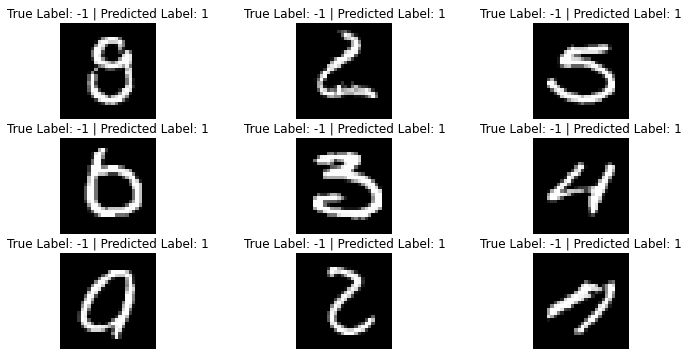

In [235]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images following the index from the array of indices index_pos
i = 0
for row in range(factor):
    for col in range(factor):
        index = index_fp[i]
        ax[row,col].imshow(X_train[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_train_0[index]) + ' | Predicted Label: ' + str(y_train_hat_0[index]))
        ax[row,col].set_axis_off()
        i += 1

plt.show()

We can do some reasoing if we look into what the perceptron is actually leaning about the digit $0$ by visualizing the weight values after the training!

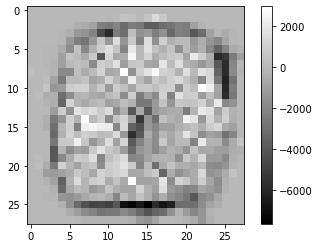

In [236]:
from matplotlib.colors import Normalize

w = prcp_clf_0.coef_
w_matrix = w.reshape(28,28)

plt.figure()
plt.imshow(w_matrix, cmap='gray')
plt.grid(False)
plt.colorbar()
plt.show()

Now, we visualize the activation by weights on a FP example.

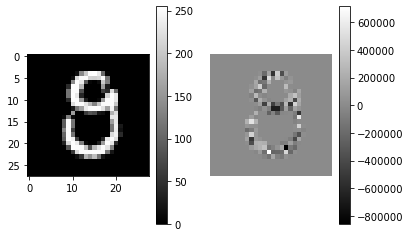

In [238]:
activation = w * X_train[index_fp[0]].reshape(1,-1)

plt.subplot(1,2,1)
plt.imshow(X_train[index_fp[0]].reshape(28,28), cmap='gray')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(activation.reshape(28,28), cmap='gray')
plt.colorbar()

plt.grid(False)
plt.axis(False)
plt.show()

In [239]:
# Input to the signum
print(np.sum(activation) + prcp_clf_0.intercept_)

[258884.]


- We can see that the model is tracing out this $8$ pretty well, and the activation and bias adds up to a positive no., which means the output is $+1$, which makes this example a False Positive.

# Multiclass Classifier (One vs All)

- We know that perceptron is a binary classifer. However, MNIST dataset contains $10$ classes.
- Inorder to tackle this issue, we basically extend the idea of binary classification to multiclass level.
- We combine mulitple binary classifiers and devise and a suitable scoring metric.
- `sklearn` makes it extremely easy. We can implement this by modifying just a few line of codes that we have written for binary classifier.
- `sklearn` does this by counting no. of unique elements (in this case $10$) in the label vector and by converting these labels using `LabelBinarizer` to fit each binary classfication (as binary classification requires binary labels).
- Let's implement this!

Let's first explore `LabelBinarizer`

In [12]:
from sklearn.preprocessing import LabelBinarizer

y_train_LB = LabelBinarizer().fit_transform(y_train)
# We dont need to convert y_test to y_test_LB, reason stated below!

In [13]:
for i in range(15):
    print(str(y_train[i]) + ' : ' + str(y_train_LB[i]))

5 : [0 0 0 0 0 1 0 0 0 0]
0 : [1 0 0 0 0 0 0 0 0 0]
4 : [0 0 0 0 1 0 0 0 0 0]
1 : [0 1 0 0 0 0 0 0 0 0]
9 : [0 0 0 0 0 0 0 0 0 1]
2 : [0 0 1 0 0 0 0 0 0 0]
1 : [0 1 0 0 0 0 0 0 0 0]
3 : [0 0 0 1 0 0 0 0 0 0]
1 : [0 1 0 0 0 0 0 0 0 0]
4 : [0 0 0 0 1 0 0 0 0 0]
3 : [0 0 0 1 0 0 0 0 0 0]
5 : [0 0 0 0 0 1 0 0 0 0]
3 : [0 0 0 1 0 0 0 0 0 0]
6 : [0 0 0 0 0 0 1 0 0 0]
1 : [0 1 0 0 0 0 0 0 0 0]


In [14]:
y_train_LB.shape

(60000, 10)

- The `i`th column in `y_train_LB` corresponds to the labels of the binary classification problem separating the digit `i` vs `not i`.
- This makes it clear why we are basically employing binary classfication $10$ times in the back-end.

In [15]:
from sklearn.linear_model import Perceptron
# Perceptron Class in itself is enough to do the multi-class classification, by converting the labels to Binarized format.

prcp_clf = Perceptron(random_state=69)
prcp_clf.fit(X_train, y_train)

Perceptron(random_state=69)

- Internally the Perceptron API automatically created the $10$ binary classifiers, converted labels to binary sparse matrix and trained them with binarized labels.
- During the inference time, the input will be passed through all these $10$ classifiers and the highest score among the output from the classifiers will be considered as the predicted class (more the score, more the chances to be above threshold, more the chances of getting a positive label from the particular classifier).
- Let's see this in action!

First let's look at the weights.

In [16]:
print("Shape of weight matrix: ", prcp_clf.coef_.shape)
print("Shape of bias vector: ", prcp_clf.intercept_.shape)

Shape of weight matrix:  (10, 784)
Shape of bias vector:  (10,)


- So, it is a $(10,784)$ matrix where each row represents the weights of a single binary classifier.
- Note that there is no sigmoid/activation function associated with the perceptron. Then how do we know the label?
- The class of perceptron that outputs the maximum score for the input sample is considered as the predicted class.

Let's verify this claim by considering the first example in the training set.

In [17]:
x0, y0 = X_train[0], y_train[0]
print(y0)

5


In [18]:
score_x0 = prcp_clf.decision_function(x0.reshape(1,-1))
print(score_x0)
y0_hat = np.argmax(score_x0)
print(y0_hat)

[[-13812502. -20844939. -15721371.  -2675996. -23825460.   3019109.
  -15132377.  -9447242. -13618558. -15174649.]]
5


As we can see, the predicted output and the label match and the model recognizes the digit as $5$.

Now, lets evaluate the model.

In [19]:
y_train_hat = prcp_clf.predict(X_train)
y_test_hat = prcp_clf.predict(X_test)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_hat))
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5923
           1       0.95      0.97      0.96      6742
           2       0.94      0.83      0.88      5958
           3       0.82      0.90      0.86      6131
           4       0.86      0.94      0.90      5842
           5       0.85      0.85      0.85      5421
           6       0.97      0.93      0.95      5918
           7       0.86      0.95      0.90      6265
           8       0.83      0.77      0.80      5851
           9       0.90      0.80      0.85      5949

    accuracy                           0.89     60000
   macro avg       0.89      0.89      0.89     60000
weighted avg       0.89      0.89      0.89     60000

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.95      0.98      0.97      1135
           2       0.96      0.80      0.87      1032
           3       0.81 

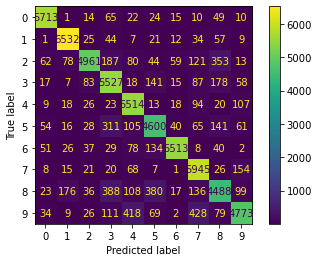

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_train_hat, values_format='.5g')
plt.show()

- We can infer that the digit $2, 5, 8$ are often confused with $3$.
- $9$ is often confused as $4$ and $7$.

### Implementing via a Pipeline

- We create a pipeline to keep the code compact.
- Although MNIST dataset is clean and doesn't require much preprocessing, we employ `MinMaxScaler` to scale the features in range $[0,1]$.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Perceptron

prcp_pipe = Pipeline([
    ('minmax_scalar', MinMaxScaler()),
    ('perceptron', Perceptron(random_state=69))
])

prcp_pipe.fit(X_train, y_train)

Pipeline(steps=[('minmax_scalar', MinMaxScaler()),
                ('perceptron', Perceptron(random_state=69))])

Let's evaluate this again.

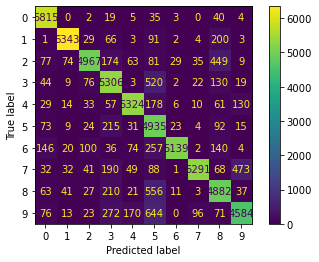

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_hat = prcp_pipe.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_train_hat, values_format='.5g')
plt.show()

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_hat))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5923
           1       0.97      0.94      0.95      6742
           2       0.93      0.83      0.88      5958
           3       0.81      0.87      0.84      6131
           4       0.93      0.91      0.92      5842
           5       0.67      0.91      0.77      5421
           6       0.99      0.87      0.92      5918
           7       0.97      0.84      0.90      6265
           8       0.80      0.83      0.81      5851
           9       0.87      0.77      0.82      5949

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.89      0.88      0.88     60000



### Let's visualize the prediction on the test set.

In [25]:
y_test_hat = prcp_clf.predict(X_test)

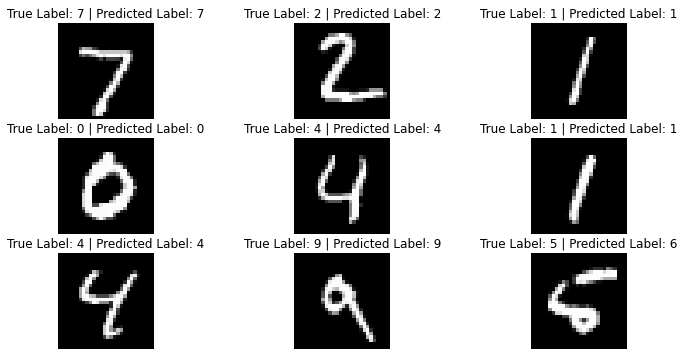

In [26]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test[index]) + ' | Predicted Label: ' + str(y_test_hat[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

## Test on my own handwritten examples

For converting my own images to `MNIST_784` format, I took help from this [video](https://www.youtube.com/watch?v=iwoLAj-SZ80).

In [27]:
import cv2
import matplotlib.pyplot as plt

In [41]:
# load image
img = r'/Users/sampadk04/Desktop/Programming/VSCode-Projects/Python/IITM_Notes/IITM-MLP/W5_Classification_Models_(Image_Classification)/digit_images/3.jpeg'

First, we take a look at this image.

In [49]:
# Convert the image to a grayscaled matrix using cv2.imread
img_converted = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

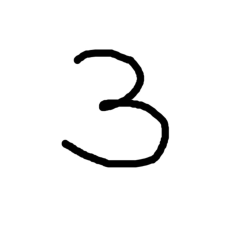

In [50]:
# Preview sample image
plt.figure()
plt.imshow(img_converted, cmap='gray')
plt.axis(False)
plt.show()

Now, this is a very high resolution picture. We need to downscale it to only 784 pixels.

In [48]:
# Resize/Format the image
img_resized = cv2.resize(img_converted, (28,28), interpolation=cv2.INTER_LINEAR)

# Flip the colours, change black to white and viceversa.
img_final = cv2.bitwise_not(img_resized)

Let's visualize the converted image.

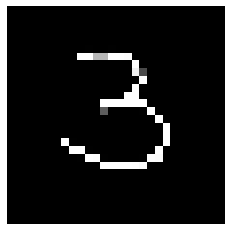

In [53]:
# Preview converted image
plt.figure()
plt.imshow(img_final, cmap='gray')
plt.axis(False)
plt.show()

I define a function that takes in the image as the argument and converts it to the MNIST_784 format.

In [63]:
# First load the image by the format:
# img = r'<path_to_image>'
def MNIST_784_converter(loaded_image):
    # Convert the image to a grayscaled matrix using cv2.imread
    img_converted = cv2.imread(loaded_image, cv2.IMREAD_GRAYSCALE)

    # Preview sample image
    plt.subplot(1,2,1)
    plt.imshow(img_converted, cmap='gray')

    # Resize/Format the image
    img_resized = cv2.resize(img_converted, (28,28), interpolation=cv2.INTER_LINEAR)

    # Flip the colours, change black to white and viceversa.
    img_final = cv2.bitwise_not(img_resized)

    # Preview converted image
    plt.subplot(1,2,2)
    plt.imshow(img_final, cmap='gray')

    plt.show()

    return img_final

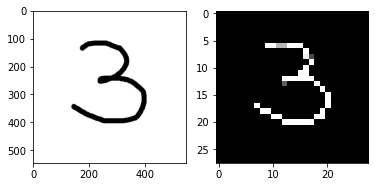

In [72]:
x = MNIST_784_converter(img)

Now, lets test this on our model!

In [73]:
x.shape

(28, 28)

We first need to reshape this.

In [74]:
x = x.reshape(1,-1)
print(x.shape)

(1, 784)


In [75]:
# The estimator is `prcp_clf`
print("Predicted Label: ", prcp_clf.predict(x))

Predicted Label:  ['3']


In [78]:
# Again to make my life easier I define a single function to do all these job-

# First load the image by the format:
# img = r'<path_to_image>'

def MNIST_predictor(loaded_image):
    x = MNIST_784_converter(loaded_image)
    x = x.reshape(1,-1)
    print("Predicted Label: ", prcp_clf.predict(x))
    return prcp_clf.predict(x)

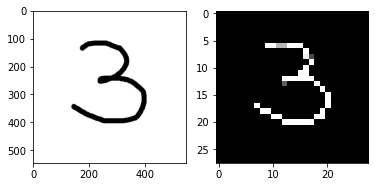

Predicted Label:  ['3']


array(['3'], dtype='<U1')

In [80]:
img3 = r'/Users/sampadk04/Desktop/Programming/VSCode-Projects/Python/IITM_Notes/IITM-MLP/W5_Classification_Models_(Image_Classification)/digit_images/3.jpeg'

MNIST_predictor(img3)

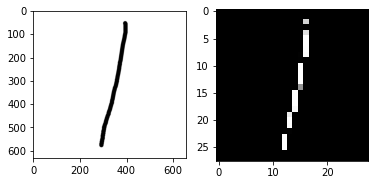

Predicted Label:  ['1']


array(['1'], dtype='<U1')

In [87]:
img1 = r'/Users/sampadk04/Desktop/Programming/VSCode-Projects/Python/IITM_Notes/IITM-MLP/W5_Classification_Models_(Image_Classification)/digit_images/1.jpeg'

MNIST_predictor(img1)

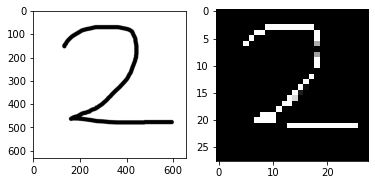

Predicted Label:  ['2']


array(['2'], dtype='<U1')

In [88]:
img2 = r'/Users/sampadk04/Desktop/Programming/VSCode-Projects/Python/IITM_Notes/IITM-MLP/W5_Classification_Models_(Image_Classification)/digit_images/2.jpeg'

MNIST_predictor(img2)

Guideline to follow while importing digit images:
- Make sure the digits are placed at the centre and are filling up the image.
- Make sure you are using black ink on white background.

# Summary:


- In this project, we use the Perceptron Classifier to clasifiy the images in MNIST_784 dataset.
- We do this in two steps:
  - Firstly, we build a binary classifier to classify digits labeled $0$ and not $0$.
  - Secondly, we combine this classifer 10 times to classify all $10$ digits in a "One vs All" fashion to build a multi-class classifier.
- We also test the models with and without cross-validations.
- We also evaluate the models via various metrics and also tried tweaking the threshold to improve the 'Precision' by looking at the PR-Curves.
- We also analyze Precision-Recall in detail.
- We conduct a Grid Search to improve the hyperparameters.
- We also analyze the behaviour of weight vector in the binary classification case, which helps explain the false positive cases to some extent.
- Finally, We also test the multi-class model on handwritten digits of my own.